In [ ]:
#!pip install nltk
#!pip install keras==2.3.1
#!pip install TensorFlow==2.1.0

In [ ]:
############## ############## ############## ############## ############## ############## ##############  
############## Install older versions of keras and tensorflow in order to run the flask app ############## 
############## ############## ############## ############## ############## ############## ############## 

#!pip install keras==2.2.5
#!pip install tensorflow==1.15.2

In [1]:
import numpy as np
import pandas as pd ; pd.options.display.max_colwidth=700 ; pd.set_option('display.max_rows', 2000)

import matplotlib.pyplot as plt 
from matplotlib import gridspec

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras import models 
from keras import Input
from keras.layers import Embedding, Flatten, Dense
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.utils import plot_model

import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import os
import re
import string
import time
import pickle
import pydot
import graphviz
from bs4 import BeautifulSoup
import warnings
from textblob import TextBlob
from textblob import Word

def function():
    warnings.warn('deprecated', DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
function()

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fi000980702/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fi000980702/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fi000980702/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/fi000980702/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: deprecated


Contents

1. [Writing negative and positive sentiments into singular files, respectively](#Writing-negative-and-positive-sentiments-into-singular-files,-respectively)
2. [Writing data into pandas dataframe](#Writing-data-into-pandas-dataframe)
3. [Visualizing sentiments](#Visualizing-sentiments)
4. [Pre-process data for the model](#Pre-process-data-for-the-model)
5. [Network architecture](#Network-architecture)

##### Read data into pandas dataframe

In [2]:
df = pd.read_csv('IMDB Dataset.csv', encoding='ISO-8859-1')          # Read data
df = df.rename(columns={'review':'text'})                            # Rename column names
df2 = df.copy()                                                      # Create a copy of the dataframe for later use
df.head(2)

,text,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and ...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard whi...",positive


#### Visualizing sentiments

Visualizing the sentiments helps to etermine whether the dataset is balanced or not. As seen from the grah below, the dataset is evenly balanced and hence we don't need to do any rebalancing for the training set later on.

In [3]:
def sentiment_distribution(data):
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 5),gridspec_kw={'width_ratios': [1,0.5]})
    keys, counts = np.unique(data, return_counts=True)
    counts_norm = counts/counts.sum()
    
    ax0.bar(['negative', 'positive'], counts, color=['dimgrey', 'lightgrey'], width=.99) 
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.tick_params(axis='x', labelsize=14)
    ax0.set_title('Sentiment absolute distribution', fontsize=16) 
    ax0.set_ylabel('Count',fontsize=14)
    ax0.text(['negative'], counts[0]/2*2, counts[0], horizontalalignment='center', fontsize=14)
    ax0.text(['positive'], counts[1]/2*2, counts[1], horizontalalignment='center', fontsize=14)

    ax1.bar(['sentiment'], [counts_norm[0]], label='negative', color=['dimgrey'])
    ax1.bar(['sentiment'], [counts_norm[1]], bottom=counts_norm[0],label='positive', color = ['lightgrey'])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=14)
    ax1.set_title('Sentiment relative distribution', fontsize=14)
    ax1.set_ylabel('Percentage', fontsize=14)
    ax1.text(['sentiment'],(counts_norm[0]/2), '{:.1f}%'.format((counts_norm[0]*100)), horizontalalignment='center', fontsize=14)
    ax1.text(['sentiment'],(counts_norm[1]/2) + counts_norm[0], '{:.1f}%'.format((counts_norm[1]*100)), horizontalalignment='center', fontsize=14)

    plt.show()

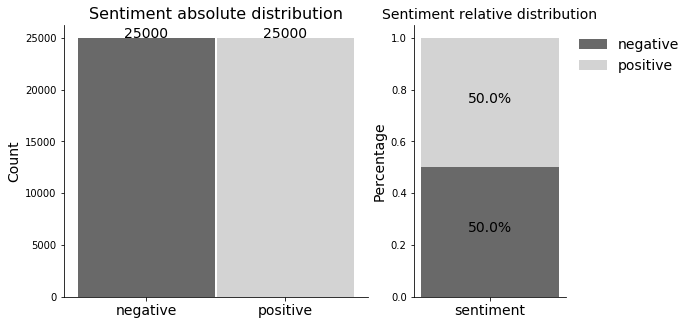

In [4]:
sentiment_distribution(df['sentiment'])

##### Visualizing word count distribution

This plot shows that the shape of the number of words per document is quite normal. The mean umber of words per document is approximately 750.


In [5]:
def word_counts_per_doc(text):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    word_counts = text.apply(lambda x: len(str(x).split()))
    ax.hist(word_counts, bins=50, color='royalblue',edgecolor='black')
    ax.axvline(word_counts.mean(), color='firebrick', linestyle='dashed')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Distribution of word counts', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xlabel('Number of words', fontsize=14)
    plt.show()

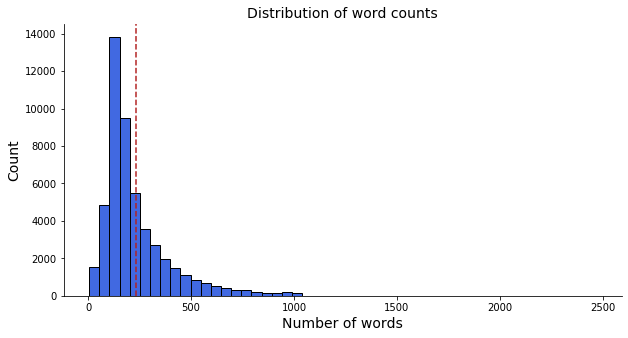

In [6]:
word_counts_per_doc(df2['text'])

#### Pre-process data for the model

 1. Clear data
 2. Convert everything into lowercase
 3. Remove rarest and most common words
 4. Remove punctuations
 5. Remove numbers
 6. Lemmatize text
 7. Remove stopwords
 8. Tokenize the data

##### Clear data

In [7]:
def clear_data(text):
    '''
    Remove unnecessary noise "\n" and replace it with an empty space
    Remove single characters replace them with an empty space
    Remove multiple spaces
    Remove html tags with BeautifulSoup
    '''   
    text = text.replace('\n', '')    
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ',text)
    text = re.sub(r'\s+', ' ', text)
    text = BeautifulSoup(text, 'lxml').text
    return text

##### Convert everything into lowercase

In [8]:
def lowercase(text):
    '''
    This ensures same words are treated equally e.g. "Banana" and "banana"
    '''
    return text.apply(lambda sentence: sentence.lower())

##### Remove punctuations

In [9]:
def remove_punctuations(text):
    '''
    Special characters, such as !@#? can create unwanted noise as they do not contribute much or at all
    to the sentiments. Therefore remove punctuations and replace them with an empty space
    '''
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

##### Remove numbers

In [10]:
def remove_numbers(df):
    '''
    Numbers typically do not hold sentimental value therefore remove numbers,
    such as year, dates, times etc. However, in this particular setting, one 
    needs to be careful because in review data there could be sentences like
    "I give this movies a 5/5 rating"
    '''
    text = ''.join(word for word in df if not word.isdigit())
    return text

##### Lemmatize text

In [11]:
def lemmatize(df):
    '''
    Lemmatize text so that same words are treated equally e.g. "bananas" becomes "banana"
    '''
    return df.apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

#### Remove stopwords

In [12]:
def remove_stopwords(df):
    '''
    These are most commonly occuring words, such as "the", "is",
    which typically do not provide additional* information value for the model.
    '''
    stop_words = set(stopwords.words('english'))
    return df.apply(lambda x: [item for item in x.split() if item not in stop_words])

In [13]:
df.head(1)

,text,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and ...",positive


In [14]:
df['text'] = df['text'].apply(clear_data)                     # 
df['text'] = lowercase(df['text'])                            #
df['text'] = df['text'].apply(remove_punctuations)            # 
df['text'] = df['text'].apply(remove_numbers)                 # Apply all functions described above
df['text'] = lemmatize(df['text'])                            #
df['text'] = remove_stopwords(df['text'])                     #
df.head(1)

,text,sentiment
0,"[one, reviewer, ha, mentioned, watching, oz, episode, youll, hooked, right, exactly, happened, methe, first, thing, struck, oz, wa, brutality, unflinching, scene, violence, set, right, word, go, trust, show, faint, hearted, timid, show, pull, punch, regard, drug, sex, violence, hardcore, classic, use, wordit, called, oz, nickname, given, oswald, maximum, security, state, penitentary, focus, mainly, emerald, city, experimental, section, prison, cell, glass, front, face, inwards, privacy, high, agenda, em, city, home, manyaryans, muslim, gangsta, latino, christian, italian, irish, moreso, scuffle, death, stare, dodgy, dealing, shady, agreement, never, far, awayi, would, say, main, appeal, ...",positive


##### Tokenize data

In [15]:
max_length = 300                                      # Max length for the input layer                                           
training_samples = 35000                              # Trains on 35000 samples
validation_samples = 15000                            # Validates on 15000 samples 
top_words = 10000                                     # Consider only the top 10000 words in the dataset 

In [16]:
def tokenize(text, top_words):
    tokenizer = Tokenizer(num_words=top_words)        # Creates a tokenizer configured to only account for top words
    tokenizer.fit_on_texts(text)                      # Builds the word index
    return tokenizer

In [17]:
def encode_text(tokenizer, text, max_length):
    sequences = tokenizer.texts_to_sequences(text)    # Converts strings into lists of integer indices
    X = pad_sequences(sequences, maxlen=max_length)   # Converts the lists of integers into a 2D integer tensor
    return X

In [18]:
def binarize_label(y):
    y = np.asarray(y)                                 # Converts the target label into numpy 
    encoder = LabelEncoder()                          # 
    encoder.fit(y)                                    # Binarize the target label
    y = encoder.transform(y)                          #
    return y

In [19]:
y = binarize_label(df['sentiment'])                               # Call function binarize_label
X = df['text']                                                    # Define X matrix
X_train = X[:training_samples]                                    # Define train data matrix 
y_train = y[:training_samples]                                    # Define train label vector 
X_val = X[training_samples : training_samples+validation_samples] # Define val data matrix 
y_val = y[training_samples : training_samples+validation_samples] # Define val label vector 

In [20]:
tokenizer = tokenize(X_train, top_words)                          # Call function tokenize
X_train = encode_text(tokenizer, X_train, max_length)             # Call function encode_text
X_val = encode_text(tokenizer, X_val, max_length)                 # Call function encode_text

In [21]:
word_index = tokenizer.word_index                             # How one can recover the word index that was computed.
print('There are {:d} unique tokens'.format(len(word_index))) # here we use it to calculate the n of unique tokens
print('X train tensor has {:d} rows and {:d} columns'.format(*X_train.shape)) # Print shape of X matrix
print('X val tensor has {:d} rows and {:d} columns'.format(*X_val.shape))     # Print shape of X matrix
print('Shape of label tensor {:d}'.format(*y.shape))                          # print shape of y vector

There are 162757 unique tokens
X train tensor has 35000 rows and 300 columns
X val tensor has 15000 rows and 300 columns
Shape of label tensor 50000


#### Network architecture

The network consists of two inception modules, where the input is processed with Dense layers which are then concatened back into single tensor. 

**Intermediate layers**

```Embedding``` I define an mean embedding layer with three parameters: first, 13000 as the number of possible tokens (top 13000 most occuring words), 128 as the the dimensionality of the embeddings and max_length of 300.

```Dense```I define three Dense layers with kernel weight regularization. 

**Last layer**

```Dense``` Because this is a binary problem, I use sigmoid function in the last layer as it will output a scalar prediction regarding the sentiment of the current review.

**Loss function**

```Binary crossentropy```Again, because this is a binary problem and the output of the network is a probability, it is best to use binary_crossentropy loss. Here, we could also use mean squared error, but the binary crossentropy loss is more feasible as we deal with a model that outputs probabilitites.

**Optimizer**

```rmsprop``` I use rmsprop optimizer as it performs well in general. I define decay to decrease the learning rate over time. Importantly, it also much faster than for example adam optimizer.

In [47]:
def nlp_model():
    input_1 = Input(shape=(max_length,), dtype='int32')
    embedding = Embedding(top_words, 128)(input_1)
    mean_embedding = keras.layers.Lambda(lambda x: K.mean(x, axis=1))(embedding)

    x1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.025))(mean_embedding)
    x2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.015))(mean_embedding)
    x3 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005))(mean_embedding)
    
    concat = concatenate([x1, x2, x3], axis=-1)
    output = Dense(1, activation='sigmoid')(concat)
    model = Model(inputs=[input_1], outputs=output)
    rmsprop = optimizers.RMSprop(lr=0.001, decay=1e-5)
    model.compile(optimizer=rmsprop, loss = 'binary_crossentropy', metrics=['acc']) 
    model.summary()
    return model 

In [48]:
start_time = time.time()                                                         # Iniate time
callbacks_list = [                                                               # Apply early stopping to stop
    keras.callbacks.EarlyStopping(                                               # training when the validation loss
    monitor='val_loss',                                                          # starts to increase during epochs
    patience=1)
]
model = nlp_model()                                                              # Call the nlp model
history = model.fit(                                                             # Fit the model
    [X_train], y_train,
    validation_data=([X_val], y_val),
    epochs=6, batch_size=64, 
    callbacks=callbacks_list)
 
total_time = (time.time() - start_time)/60                                       # Calculate the total time that it 
print('Execution time {:2f} minutes'.format(total_time))                         # took to train the model in minutes
model.save('sentiment_model.h5')                                                 # Save the model to a hdf5 file

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 300, 128)     1280000     input_4[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128)          0           embedding_4[0][0]                
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 256)          33024       lambda_4[0][0]                   
____________________________________________________________________________________________

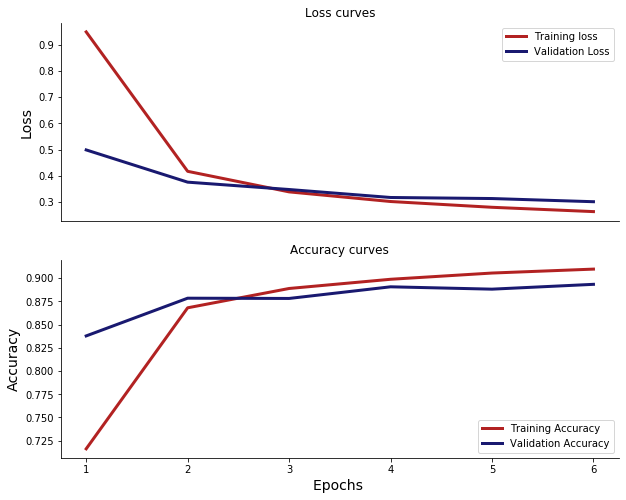

In [49]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

In [50]:
with open('tokenizer.pickle', 'wb') as handle:                              # Save the tokenizer to a pickle file
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 
with open('tokenizer.pickle', 'rb') as handle:                              # Access the tokenizer
    loaded_tokenizer = pickle.load(handle)

In [51]:
def predict(text):
    '''
    The closer the number gets to 1, the 'more' positive the sentiment. Vice versa, 
    the clsoer the number gets to 0, the 'more' negative the sentiment.
    '''
    model = keras.models.load_model('sentiment_model.h5', custom_objects={"backend":K})
    seq = loaded_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length)
    pred = model.predict(padded)
    print(pred)

In [52]:
predict("this is a great movie. i like it where ning climbs down to get his ink, \
        and the skeletons chase him, but luckily he dodged them, opened the window, \
        and didn't even notice them. xiao qian is very pretty too. \
        & when he stuck the needle up ma Wu's butt, its hysterical. \
        and when he is saying love is the greatest thing on earth while standing between two swords is great too. \
        then also the part where he eats his buns while watching thew guy kill many people. \
        then you see him chanting poems as he ran to escape the wolves. the love scenes are romantic, \
        xiao qian and ning look cute together. add the comic timing, the giant tongue, and u have horror, \
        romance, comedy, all at once. not to mention superb special effects for the 90s.")

[[0.9374817]]


In [53]:
predict("We brought this film as a joke for a friend, and could of been our worst joke to play. \
        The film is barely watchable, and the acting is dire. \
        The worst child actor ever used and Hasslehoff giving a substandard performance. \
        The plot is disgraceful and at points we was so bored we was wondering what the hell was going on. \
        It tries to be gruesome in places but is just laughable.<br /><br />Just terrible")

[[0.00380402]]


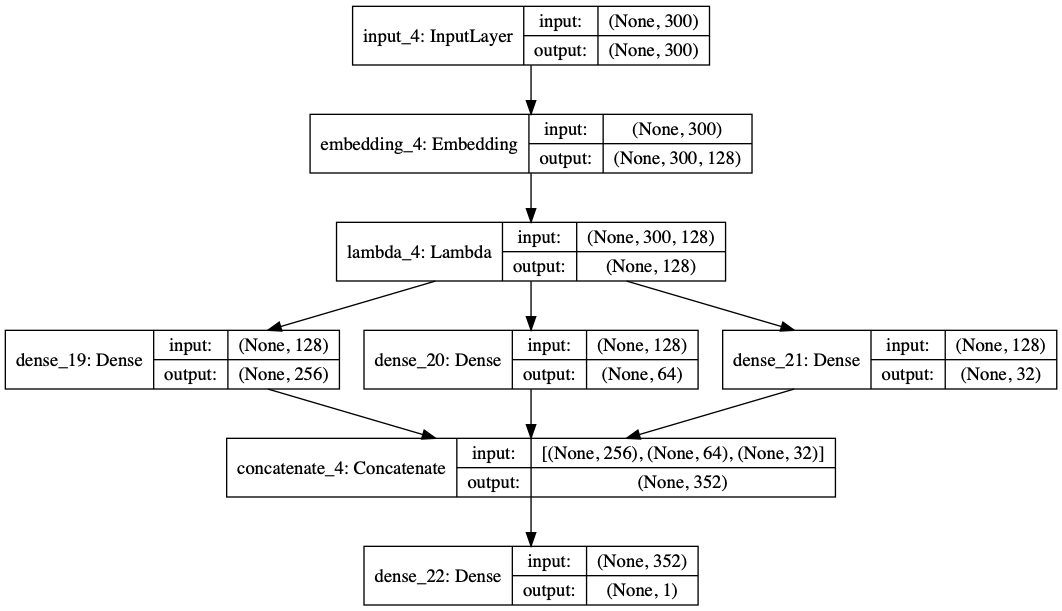

In [54]:
plot_model(model, show_shapes=True, to_file='model.png')